In [1]:
! [ -e /content ] && pip install -Uqq fastai CGDs && rm -rf /usr/local/lib/python3.7/dist-packages/examples # colab

In [2]:
#!nvidia-smi

In [3]:
! rm -rf /content/fastai3-reactor/examples/records

In [4]:
#%cd ..
%cd fastai3-reactor

/content/fastai3-reactor


In [5]:
import torch.nn as nn
from CGDs import ACGD
from fastai.vision.all import *
from fastai.vision.gan import generate_noise
from src.GAN.gan_learner_a import *
from src.GAN.gan_learner_b import *
from src.GAN.loss import *
from src.GAN.evolution_recorder import *
from src.GAN.augmentation import *
from examples.models.mnist_gan import *

Here you can see how to install augmentation on some abstract `GANLearner` when you have access to GAN specific events

In [6]:
# we won't use valid ds
@patch    
def _do_epoch_validate(self:GANLearnerA, ds_idx=1, dl=None):
    pass

@patch    
def _do_epoch_validate(self:GANLearnerB, ds_idx=1, dl=None):
    pass

In [7]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [8]:
def noise_fn(size):
    return lambda fn: generate_noise(fn, size=size)

In [9]:
bs = 64
lr = 1e-4
epochs = 20
loss = CrossEntropyLoss()
nz = 100

We will train only on 64 images

In [10]:
dblock = DataBlock((TransformBlock, ImageBlock(cls=PILImageBW)),
                   get_items=get_image_files,
                   getters=[noise_fn(nz), lambda path: path],
                   splitter=TrainTestSplitter(train_size=0.01),
                   batch_tfms=Normalize.from_stats([0.5], [0.5]))

dls = dblock.dataloaders(path, bs=bs, seed=41)

In [11]:
len(dls.train)

10

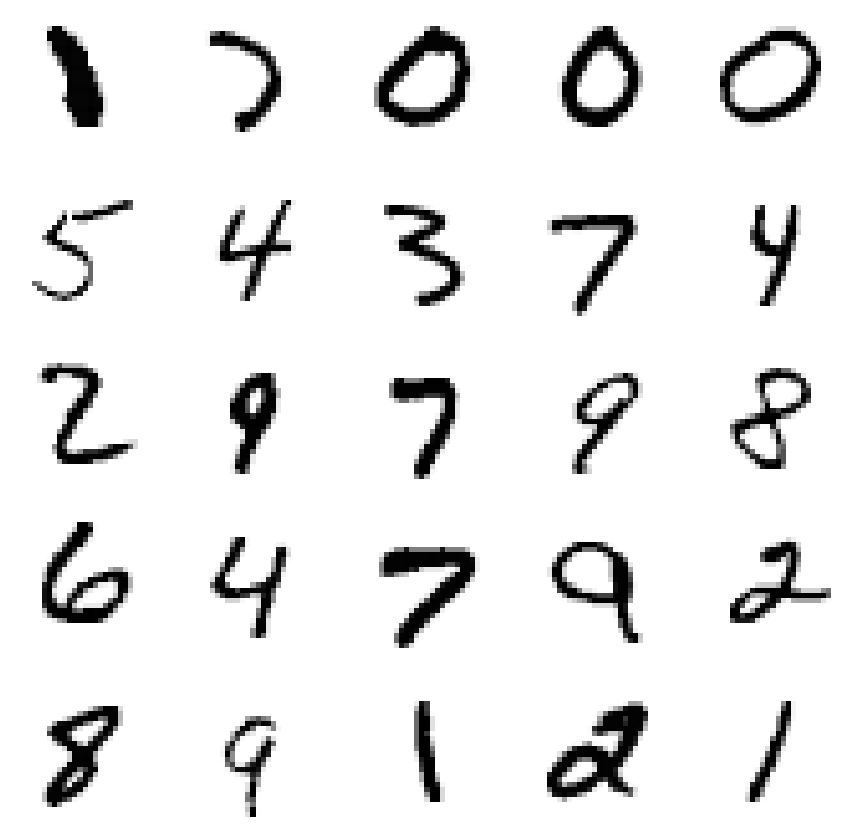

In [12]:
dls.show_batch(max_n=25)

# With augmentation

https://arxiv.org/pdf/2006.06676.pdf

In [13]:
gen = Generator(nz).cuda()
dis = Discriminator().cuda()

In [14]:
PadMode() # zeros will not work because images a in range [-1, 1]

PadMode(Zeros='zeros', Border='border', Reflection='reflection')

In [15]:
aug = GANAugmentation(aug_transforms(do_flip=False, max_lighting=0, pad_mode='border'))

In [16]:
rec1 = TempRecorderA(50)
rec2 = GANEvolutionRecorder(every_k=100, max_n=64, storege_path='examples/records/03/1')
cbs = [aug, rec1, rec2]

In [17]:
learn = GANLearnerA(dls, gen, dis, loss, cbs=cbs)
learn.fit(epochs*100, lr)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


gen_loss=0.70789, dis_loss=0.69708
gen_loss=0.56569, dis_loss=0.73063
gen_loss=0.66288, dis_loss=0.79863
gen_loss=0.64544, dis_loss=0.80958
gen_loss=0.67988, dis_loss=0.70545
gen_loss=0.33765, dis_loss=1.55102
gen_loss=0.62113, dis_loss=1.16677
gen_loss=0.51448, dis_loss=1.05413
gen_loss=0.49386, dis_loss=1.20331
gen_loss=0.50560, dis_loss=1.14175
gen_loss=0.74715, dis_loss=0.90502
gen_loss=0.79981, dis_loss=0.85470
gen_loss=0.68628, dis_loss=0.83294
gen_loss=0.41969, dis_loss=1.25852
gen_loss=0.70845, dis_loss=3.67036
gen_loss=0.55695, dis_loss=1.42430
gen_loss=0.64050, dis_loss=0.96624
gen_loss=0.66039, dis_loss=0.97204
gen_loss=0.50665, dis_loss=1.33864
gen_loss=0.53424, dis_loss=1.39982
gen_loss=0.72144, dis_loss=1.88558
gen_loss=0.64469, dis_loss=1.08423
gen_loss=0.45396, dis_loss=1.45037
gen_loss=0.48658, dis_loss=1.34988
gen_loss=0.51017, dis_loss=1.18966
gen_loss=0.53537, dis_loss=1.22699
gen_loss=0.58934, dis_loss=1.27808
gen_loss=0.51153, dis_loss=1.14185
gen_loss=0.44510, di

In [18]:
rec2.plot_animation()

# With augmentation and custom learner

In [25]:
gen = Generator(nz).cuda()
dis = Discriminator().cuda()

In [26]:
rec1 = TempRecorderB(1)#50)
rec2 = GANEvolutionRecorder(every_k=100//4, max_n=64, storege_path='examples/records/03/3')
cbs = [aug, rec1, rec2]

Unfortunatly, augmentation transforms cannot work with Hessians which are reqiered to this minimax optimizer, but in theory GAN specific callbacks can be installed on **any** `GANLearner` inherited from `AbstractGANLearner`.

In [27]:
minimax_opt = partial(ACGD, device='cuda')
learn = GANLearnerB(dls, gen, dis, loss, minimax_opt=minimax_opt, cbs=cbs)
learn.fit(3*100)#, lr)

RuntimeError: ignored

In [ ]:
rec2.plot_animation()